In [17]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('default')

In [18]:
# Set some display options for better viewing
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')

In [19]:
try:
    df = pd.read_excel(r"C:\Users\VAIBHAV ADMANE\Downloads\1730285881-Airbnb_Open_Data (1).xlsx")
    print("Dataset loaded successfully!")
    print("Shape of dataset:", df.shape)
except FileNotFoundError:
    print("Error: File not found. Please check the file path.")
except Exception as e:
    print("An error occurred:", e)

Dataset loaded successfully!
Shape of dataset: (102599, 26)


In [20]:
# Display the first 5 rows and basic info
if 'df' in locals():
    print("First 5 rows of the dataset:")
    print(df.head())

First 5 rows of the dataset:
        id                                              NAME      host id  \
0  1001254                Clean & quiet apt home by the park  80014485718   
1  1002102                             Skylit Midtown Castle  52335172823   
2  1002403               THE VILLAGE OF HARLEM....NEW YORK !  78829239556   
3  1002755                                               NaN  85098326012   
4  1003689  Entire Apt: Spacious Studio/Loft by central park  92037596077   

  host_identity_verified host name neighbourhood group neighbourhood  \
0            unconfirmed  Madaline            Brooklyn    Kensington   
1               verified     Jenna           Manhattan       Midtown   
2                    NaN     Elise           Manhattan        Harlem   
3            unconfirmed     Garry            Brooklyn  Clinton Hill   
4               verified    Lyndon           Manhattan   East Harlem   

        lat      long        country country code  instant_bookable  \
0  4

In [21]:
print("\nDataset Information:")
df.info()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102599 entries, 0 to 102598
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   id                              102599 non-null  int64         
 1   NAME                            102329 non-null  object        
 2   host id                         102599 non-null  int64         
 3   host_identity_verified          102310 non-null  object        
 4   host name                       102191 non-null  object        
 5   neighbourhood group             102570 non-null  object        
 6   neighbourhood                   102583 non-null  object        
 7   lat                             102591 non-null  float64       
 8   long                            102591 non-null  float64       
 9   country                         102067 non-null  object        
 10  country code                    10

### Geospatial Heatmap of Listing Density

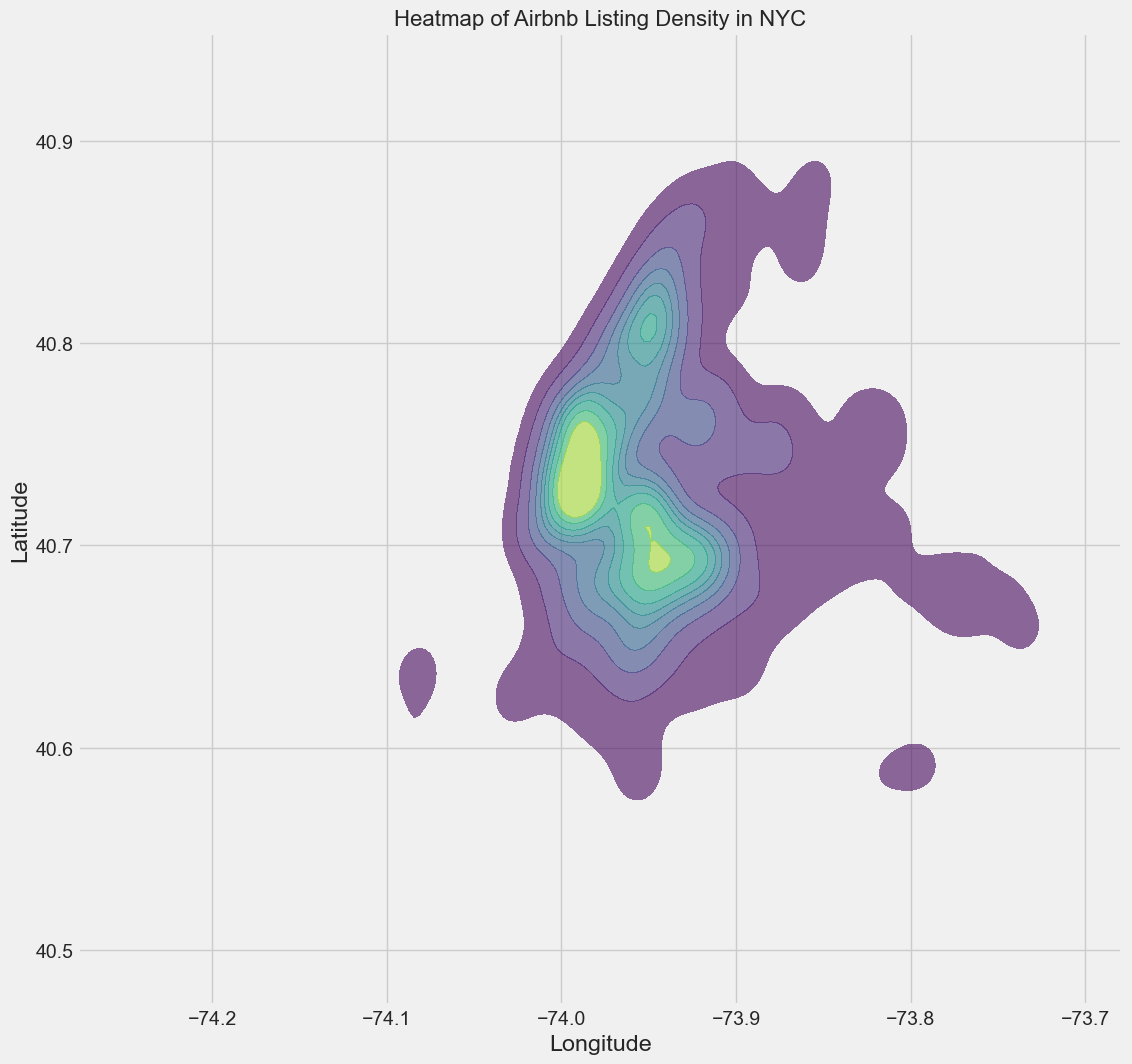

In [22]:
# Use a sample of the data to avoid overplotting, especially for a dense city like NYC
df_sample = df_cleaned.sample(n=10000, random_state=42)

plt.figure(figsize=(12, 12))
# Use seaborn's kdeplot to create a density "heatmap"
sns.kdeplot(
    x=df_sample['long'], 
    y=df_sample['lat'], 
    fill=True, 
    cmap='viridis', 
    alpha=0.6
)
plt.title('Heatmap of Airbnb Listing Density in NYC', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### Box Plot of Price by Neighbourhood Group

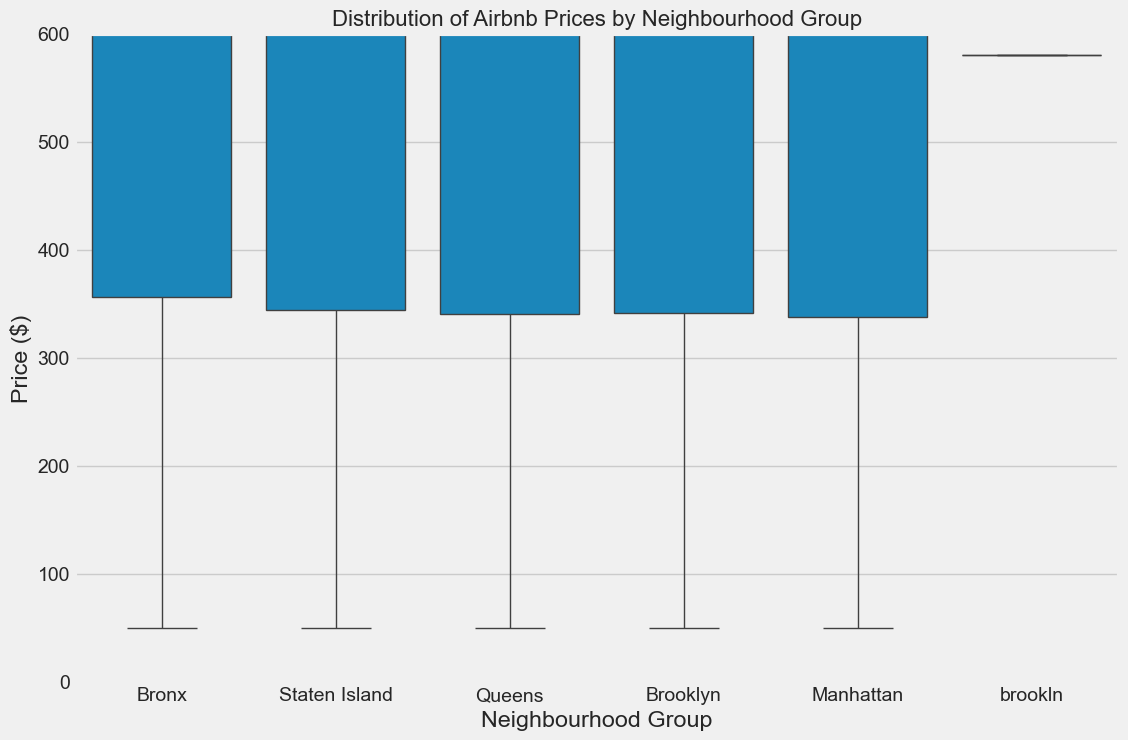

In [23]:
plt.figure(figsize=(12, 8))
sns.boxplot(
    x='neighbourhood_group', 
    y='price', 
    data=df_cleaned,
    order=df_cleaned.groupby('neighbourhood_group')['price'].median().sort_values(ascending=False).index # Order by median price
)
# Filter y-axis to remove extreme outliers and make the plot readable
plt.ylim(0, 600)
plt.title('Distribution of Airbnb Prices by Neighbourhood Group', fontsize=16)
plt.xlabel('Neighbourhood Group')
plt.ylabel('Price ($)')
plt.show()

### Correlation Heatmap

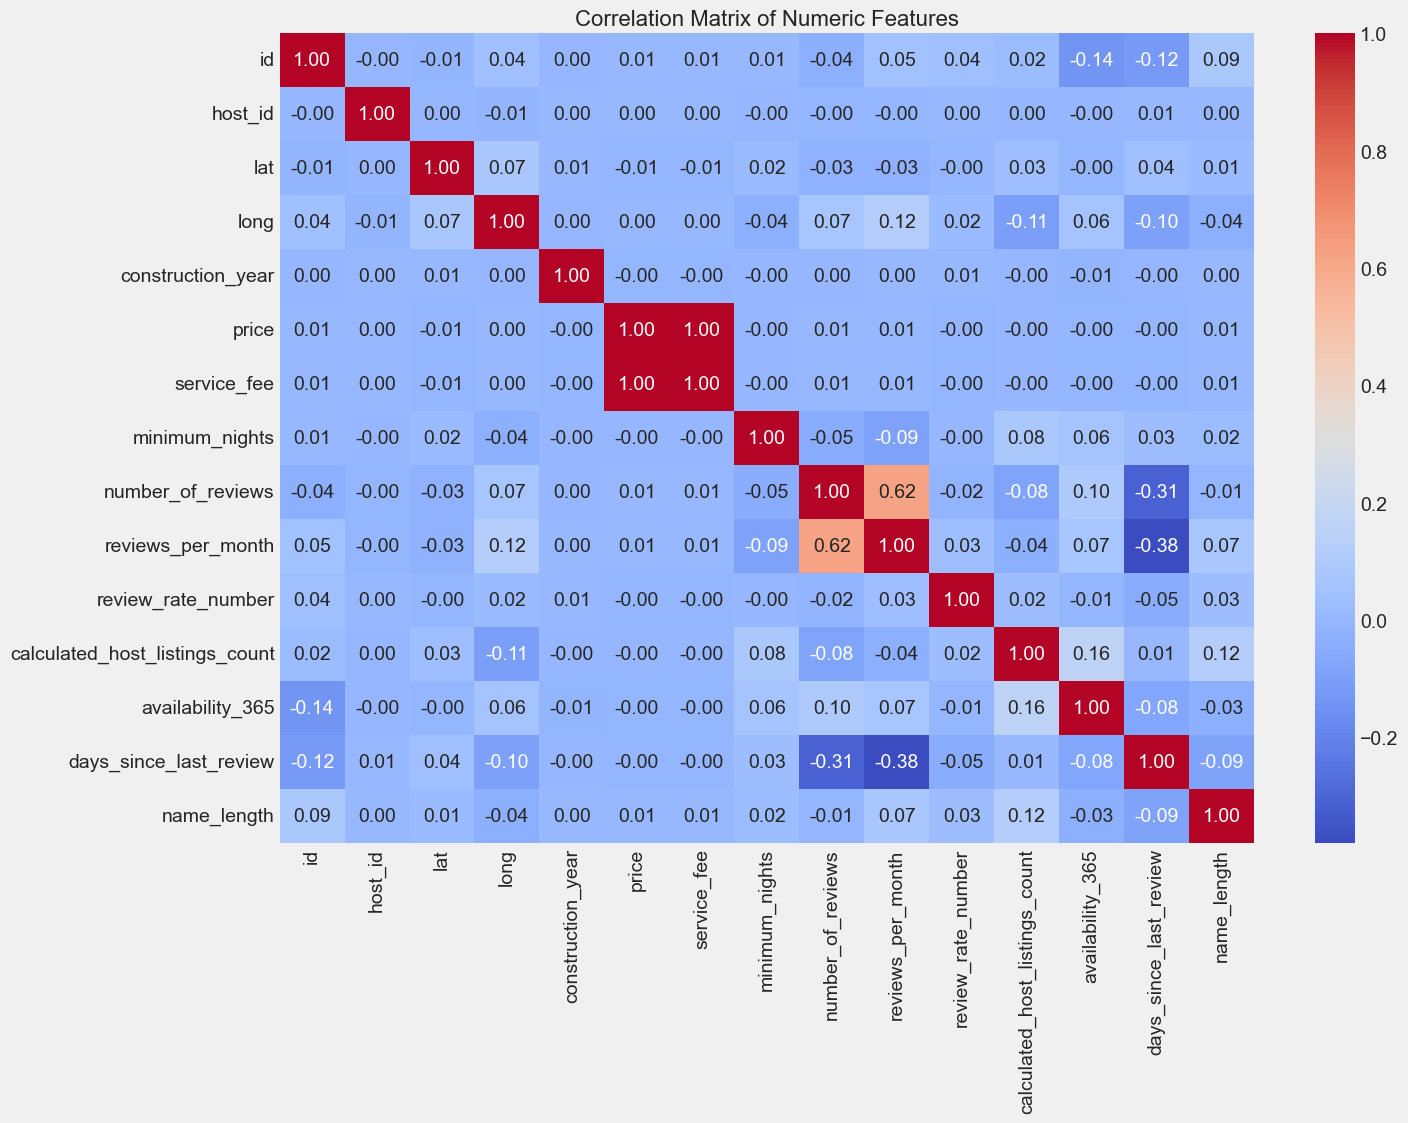

In [24]:
# Select only the numeric columns for the correlation matrix
numeric_cols = df_cleaned.select_dtypes(include=np.number)

# Calculate the correlation matrix
corr_matrix = numeric_cols.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_matrix, 
    annot=True, # Show the correlation values on the map
    cmap='coolwarm', 
    fmt='.2f' # Format to 2 decimal places
)
plt.title('Correlation Matrix of Numeric Features', fontsize=16)
plt.show()

In [25]:
 def final_clean_airbnb_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Cleans and preprocesses the Airbnb DataFrame by merging best practices.
    This function:
    1. Standardizes all column names.
    2. Drops columns that provide little to no value for analysis.
    3. Handles missing values using targeted strategies (dropping, filling).
    4. Converts columns to their correct and most efficient data types.
    5. Removes invalid data points and basic outliers.
    """
    print("--- Starting Final Data Cleaning and Preprocessing ---")

    # 1. Standardize Column Names (from both scripts)
    # This is the crucial first step. All subsequent steps will use these new names.
    df.columns = df.columns.str.replace(' ', '_').str.lower()
    print("Step 1: Column names standardized to lowercase with underscores.")

    # 2. Drop Unnecessary Columns (from my refined script)
    # Based on your df.info(), 'license' is ~100% null and 'country'/'country_code' are redundant.
    columns_to_drop = ['license', 'country', 'country_code']
    df.drop(columns=columns_to_drop, inplace=True, errors='ignore') # errors='ignore' prevents error if columns are already gone
    print(f"Step 2: Dropped unnecessary columns: {columns_to_drop}")

    # 3. Handle Missing Values (Combined & Improved Logic)
    
    # 3a. Drop rows where critical information is missing.
    # This covers 'name' and 'host_name' from your script, plus other essentials.
    critical_cols = ['name', 'host_name', 'price', 'service_fee', 'neighbourhood_group']
    df.dropna(subset=critical_cols, inplace=True)
    
    # 3b. Fill 'reviews_per_month' with 0. This logic is correct in both scripts.
    df['reviews_per_month'].fillna(0, inplace=True)
    
    # 3c. Fill 'house_rules' with a placeholder.
    df['house_rules'].fillna('Not specified', inplace=True)

    # 3d. Fill remaining numeric columns with their median for robustness.
    numeric_cols_to_fill = ['minimum_nights', 'number_of_reviews', 'review_rate_number', 'calculated_host_listings_count', 'availability_365', 'construction_year']
    for col in numeric_cols_to_fill:
        if df[col].isnull().any():
            median_val = df[col].median()
            df[col].fillna(median_val, inplace=True)
            
    print("Step 3: Missing values handled systematically.")

    # 4. Correct Data Types (Improved Logic)
    # Note: The block for removing '$' is removed because your data is already numeric.
    
    # 4a. Convert 'last_review' to datetime.
    # We do this BEFORE filling, allowing us to keep NaT for missing dates,
    # which is better for analysis than filling with a string like 'Not Available'.
    df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')

    # 4b. Convert float columns that should be integers.
    int_cols = ['price', 'service_fee', 'minimum_nights', 'number_of_reviews', 'review_rate_number', 
                'calculated_host_listings_count', 'availability_365', 'construction_year']
    for col in int_cols:
        df[col] = df[col].astype(int)

    # 4c. Convert 'instant_bookable' to a more intuitive boolean type.
    if 'instant_bookable' in df.columns:
        df['instant_bookable'] = df[df['instant_bookable'].isin([0.0, 1.0])]['instant_bookable'].astype(bool)

    print("Step 4: Data types corrected and optimized.")

    # 5. Remove Invalid Data / Outliers
    # A listing with a price of $0 is not valid for analysis.
    initial_rows = len(df)
    df = df[df['price'] > 0].copy() # .copy() prevents a pandas warning
    print(f"Step 5: Removed {initial_rows - len(df)} rows with invalid price (e.g., $0).")
    
    print("\n--- Data Wrangling Complete! ---")
    print(f"Final shape of the cleaned dataset: {df.shape}")
    
    return df


In [26]:
 # --- How to use the final function ---
#Assuming your original DataFrame is named 'df'
df_cleaned = final_clean_airbnb_data(df.copy())

--- Starting Final Data Cleaning and Preprocessing ---
Step 1: Column names standardized to lowercase with underscores.
Step 2: Dropped unnecessary columns: ['license', 'country', 'country_code']
Step 3: Missing values handled systematically.
Step 4: Data types corrected and optimized.
Step 5: Removed 0 rows with invalid price (e.g., $0).

--- Data Wrangling Complete! ---
Final shape of the cleaned dataset: (101424, 23)


C:\Users\VAIBHAV ADMANE\AppData\Local\Temp\ipykernel_11448\1448722169.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['reviews_per_month'].fillna(0, inplace=True)
C:\Users\VAIBHAV ADMANE\AppData\Local\Temp\ipykernel_11448\1448722169.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves 

In [27]:
 # Verify the final cleaned data
print("\n--- Information of the Final Cleaned DataFrame ---")
df_cleaned.info()


--- Information of the Final Cleaned DataFrame ---
<class 'pandas.core.frame.DataFrame'>
Index: 101424 entries, 0 to 102598
Data columns (total 23 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   id                              101424 non-null  int64         
 1   name                            101424 non-null  object        
 2   host_id                         101424 non-null  int64         
 3   host_identity_verified          101160 non-null  object        
 4   host_name                       101424 non-null  object        
 5   neighbourhood_group             101424 non-null  object        
 6   neighbourhood                   101409 non-null  object        
 7   lat                             101416 non-null  float64       
 8   long                            101416 non-null  float64       
 9   instant_bookable                101338 non-null  object        
 10  cancellat

In [28]:
 print("\n--- Descriptive Statistics ---")
print(df_cleaned.describe())


--- Descriptive Statistics ---
                 id       host_id            lat           long  \
count  1.014240e+05  1.014240e+05  101416.000000  101416.000000   
mean   2.918954e+07  4.923326e+10      40.728067     -73.949661   
min    1.001254e+06  1.236005e+08      40.499790     -74.249840   
25%    1.509755e+07  2.456154e+10      40.688720     -73.982580   
50%    2.918880e+07  4.908197e+10      40.722300     -73.954440   
75%    4.324635e+07  7.395979e+10      40.762750     -73.932340   
max    5.735803e+07  9.876313e+10      40.916970     -73.705220   
std    1.624964e+07  2.853426e+10       0.055861       0.049498   

       construction_year          price    service_fee  minimum_nights  \
count      101424.000000  101424.000000  101424.000000   101424.000000   
mean         2012.483870     625.191976     125.039034        8.079675   
min          2003.000000      50.000000      10.000000    -1223.000000   
25%          2008.000000     340.000000      68.000000        2.0000

### Listing Landscape (Counts & Types)

C:\Users\VAIBHAV ADMANE\AppData\Local\Temp\ipykernel_11448\3597081160.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x=listings_per_group.index, y=listings_per_group.values, palette='viridis')
C:\Users\VAIBHAV ADMANE\AppData\Local\Temp\ipykernel_11448\3597081160.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], x=listings_per_room_type.index, y=listings_per_room_type.values, palette='plasma')


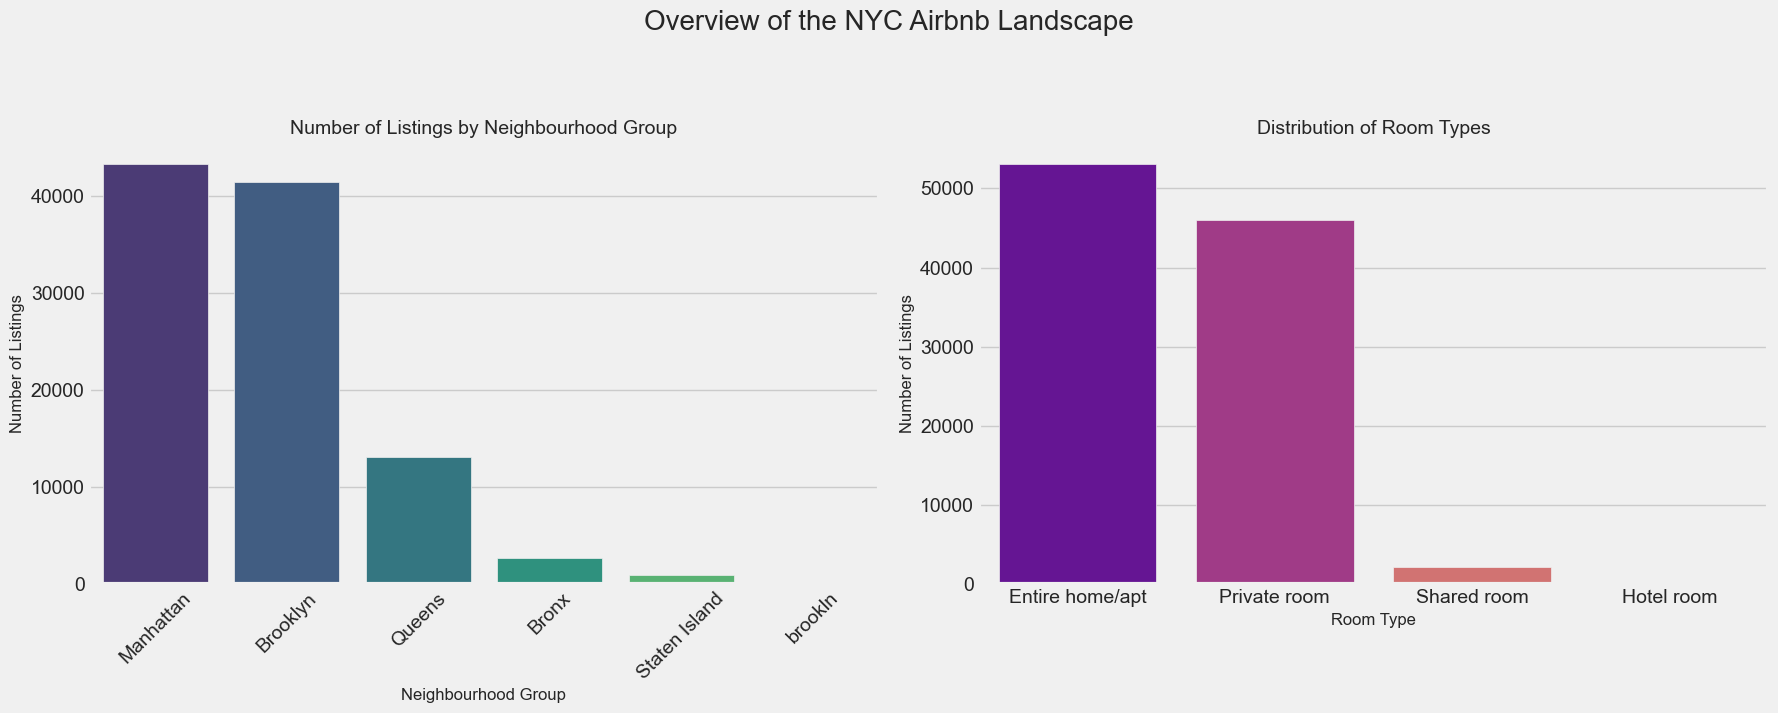

In [29]:
# Count listings in each neighbourhood group
listings_per_group = df_cleaned['neighbourhood_group'].value_counts()

# Count listings for each room type
listings_per_room_type = df_cleaned['room_type'].value_counts()
# Create a figure with two subplots side by side (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Overview of the NYC Airbnb Landscape', fontsize=20, y=1.02) # Main title

# Left Plot: Bar Chart of Listings per Neighbourhood Group
sns.barplot(ax=axes[0], x=listings_per_group.index, y=listings_per_group.values, palette='viridis')
axes[0].set_title('Number of Listings by Neighbourhood Group', fontsize=14)
axes[0].set_xlabel('Neighbourhood Group', fontsize=12)
axes[0].set_ylabel('Number of Listings', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Right Plot: Bar Chart of Room Type Distribution
sns.barplot(ax=axes[1], x=listings_per_room_type.index, y=listings_per_room_type.values, palette='plasma')
axes[1].set_title('Distribution of Room Types', fontsize=14)
axes[1].set_xlabel('Room Type', fontsize=12)
axes[1].set_ylabel('Number of Listings', fontsize=12)

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust for suptitle
plt.show()

###  Economic Analysis (Pricing & Fees)

C:\Users\VAIBHAV ADMANE\AppData\Local\Temp\ipykernel_11448\1793360712.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x=avg_price_per_group.index, y=avg_price_per_group.values, palette='coolwarm')


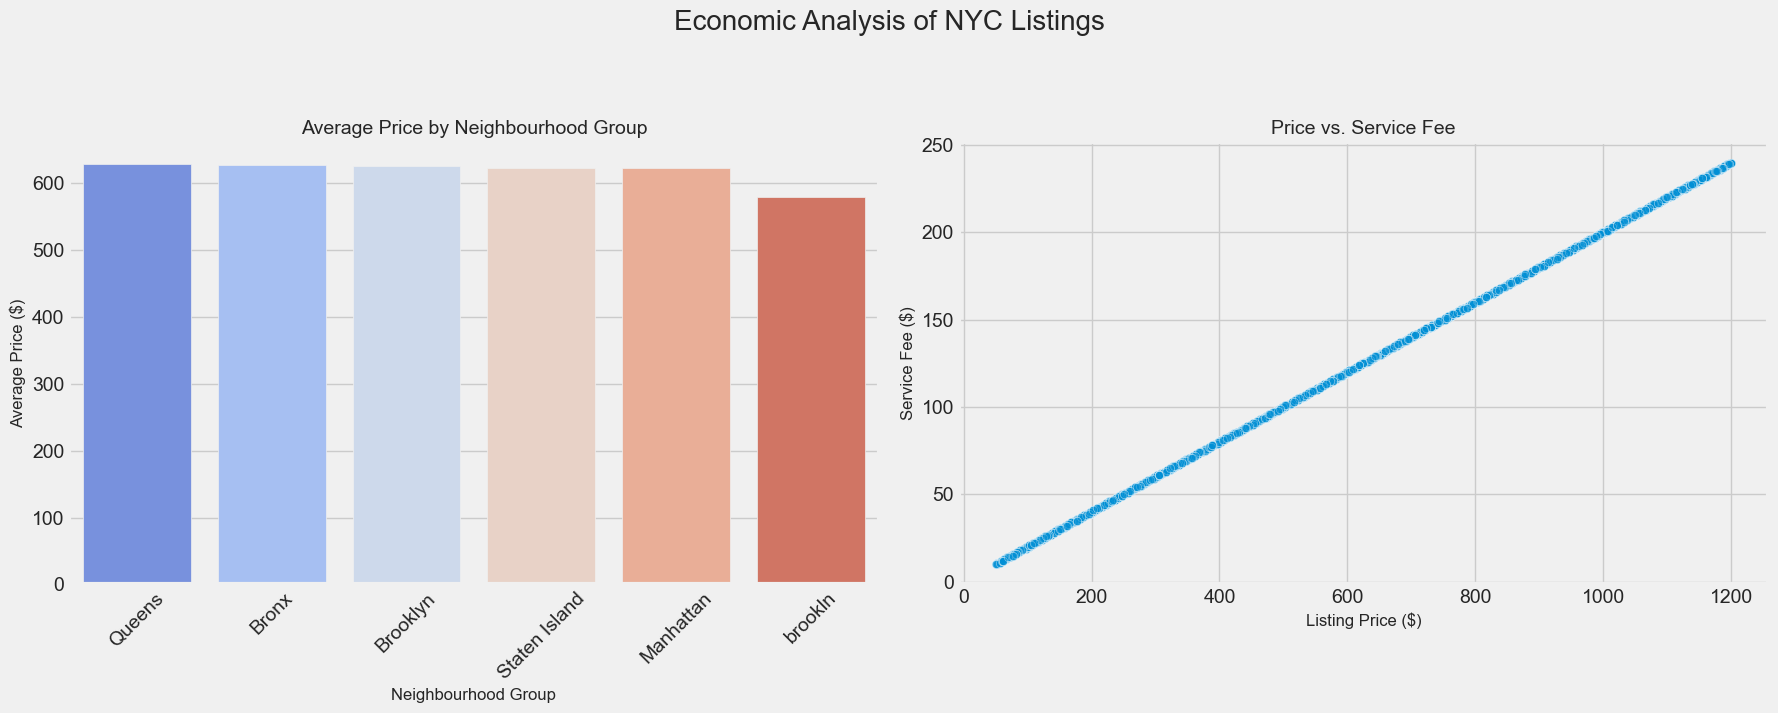

In [30]:
# Calculate the average price for each neighbourhood group
avg_price_per_group = df_cleaned.groupby('neighbourhood_group')['price'].mean().sort_values(ascending=False)


# --- Visualization ---
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Economic Analysis of NYC Listings', fontsize=20, y=1.02)

# Left Plot: Bar Chart of Average Price by Neighbourhood Group
sns.barplot(ax=axes[0], x=avg_price_per_group.index, y=avg_price_per_group.values, palette='coolwarm')
axes[0].set_title('Average Price by Neighbourhood Group', fontsize=14)
axes[0].set_xlabel('Neighbourhood Group', fontsize=12)
axes[0].set_ylabel('Average Price ($)', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Right Plot: Scatter Plot of Price vs. Service Fee
# We filter out extreme prices to make the linear trend more visible
sns.scatterplot(ax=axes[1], x='price', y='service_fee', data=df_cleaned[df_cleaned['price'] < 1500], alpha=0.5)
axes[1].set_title('Price vs. Service Fee', fontsize=14)
axes[1].set_xlabel('Listing Price ($)', fontsize=12)
axes[1].set_ylabel('Service Fee ($)', fontsize=12)

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

###  Host Activity & Guest Satisfaction

C:\Users\VAIBHAV ADMANE\AppData\Local\Temp\ipykernel_11448\2276453355.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x=top_10_hosts.values, y=top_10_hosts.index, palette='mako', orient='h')
C:\Users\VAIBHAV ADMANE\AppData\Local\Temp\ipykernel_11448\2276453355.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[1], x='review_rate_number', y='neighbourhood_group', data=df_cleaned, palette='rocket')


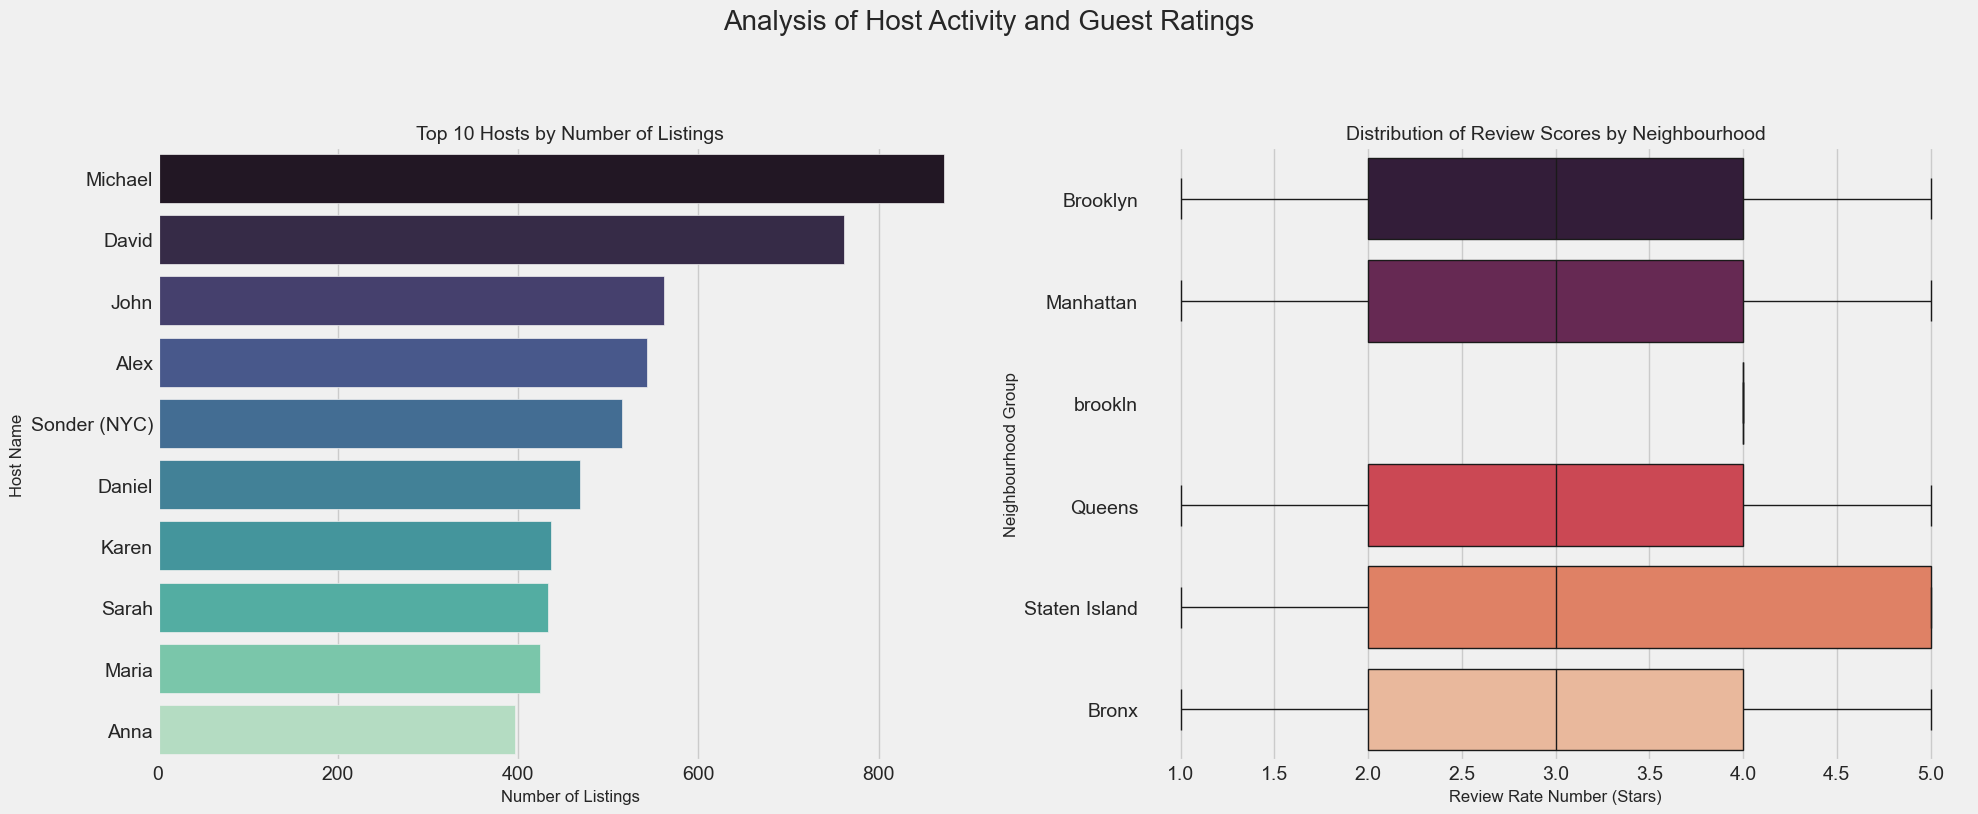

In [31]:
# --- Data Preparation ---
# Find the top 10 hosts by the number of listings they have
top_10_hosts = df_cleaned['host_name'].value_counts().nlargest(10)


# --- Visualization ---
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Analysis of Host Activity and Guest Ratings', fontsize=20, y=1.02)

# Left Plot: Horizontal Bar Chart of Top 10 Hosts
sns.barplot(ax=axes[0], x=top_10_hosts.values, y=top_10_hosts.index, palette='mako', orient='h')
axes[0].set_title('Top 10 Hosts by Number of Listings', fontsize=14)
axes[0].set_xlabel('Number of Listings', fontsize=12)
axes[0].set_ylabel('Host Name', fontsize=12)

# Right Plot: Box Plot of Review Scores by Neighbourhood Group
sns.boxplot(ax=axes[1], x='review_rate_number', y='neighbourhood_group', data=df_cleaned, palette='rocket')
axes[1].set_title('Distribution of Review Scores by Neighbourhood', fontsize=14)
axes[1].set_xlabel('Review Rate Number (Stars)', fontsize=12)
axes[1].set_ylabel('Neighbourhood Group', fontsize=12)

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

 ### Q1: What are the different property types (room types) in the Dataset?

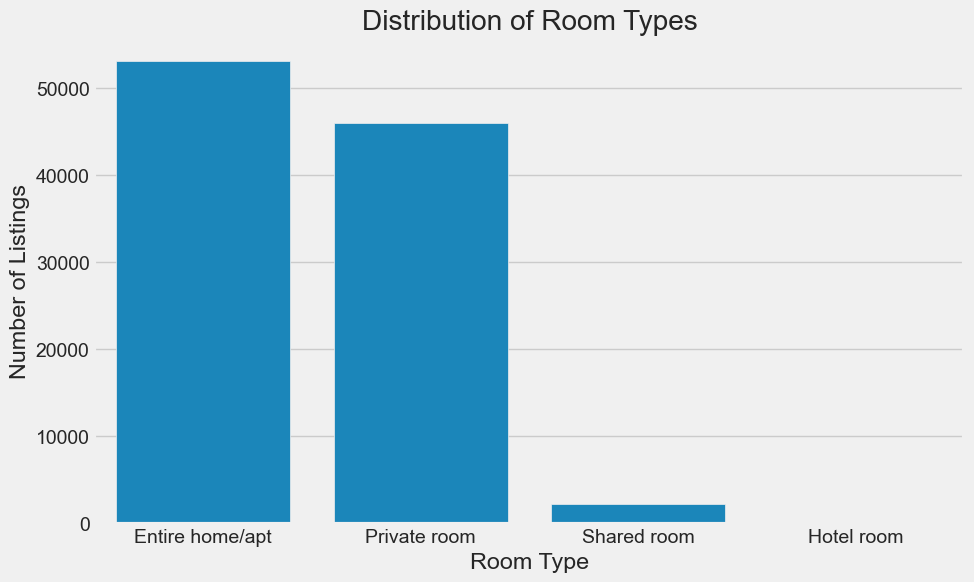

Room Type Counts:
room_type
Entire home/apt    53147
Private room       45960
Shared room         2203
Hotel room           114
Name: count, dtype: int64


In [32]:
# --- Q1: Different Room Types ---
if 'df_cleaned' in locals():
    plt.figure(figsize=(10, 6))
    # Use seaborn for a nice-looking count plot
    sns.countplot(x='room_type', data=df_cleaned, order=df_cleaned['room_type'].value_counts().index)
    plt.title('Distribution of Room Types')
    plt.xlabel('Room Type')
    plt.ylabel('Number of Listings')
    plt.show()

    # Print the exact counts
    print("Room Type Counts:")
    print(df_cleaned['room_type'].value_counts())

### Q2 & Q3: Which neighborhood group has the highest number of listings and the highest average prices?

Neighborhood Group Statistics (Listings Count & Avg. Price):
                     count        mean
neighbourhood_group                   
Manhattan            43302  622.595377
Brooklyn             41369  626.290580
Queens               13124  629.931195
Bronx                 2684  627.548063
Staten Island          944  623.617585
brookln                  1  580.000000


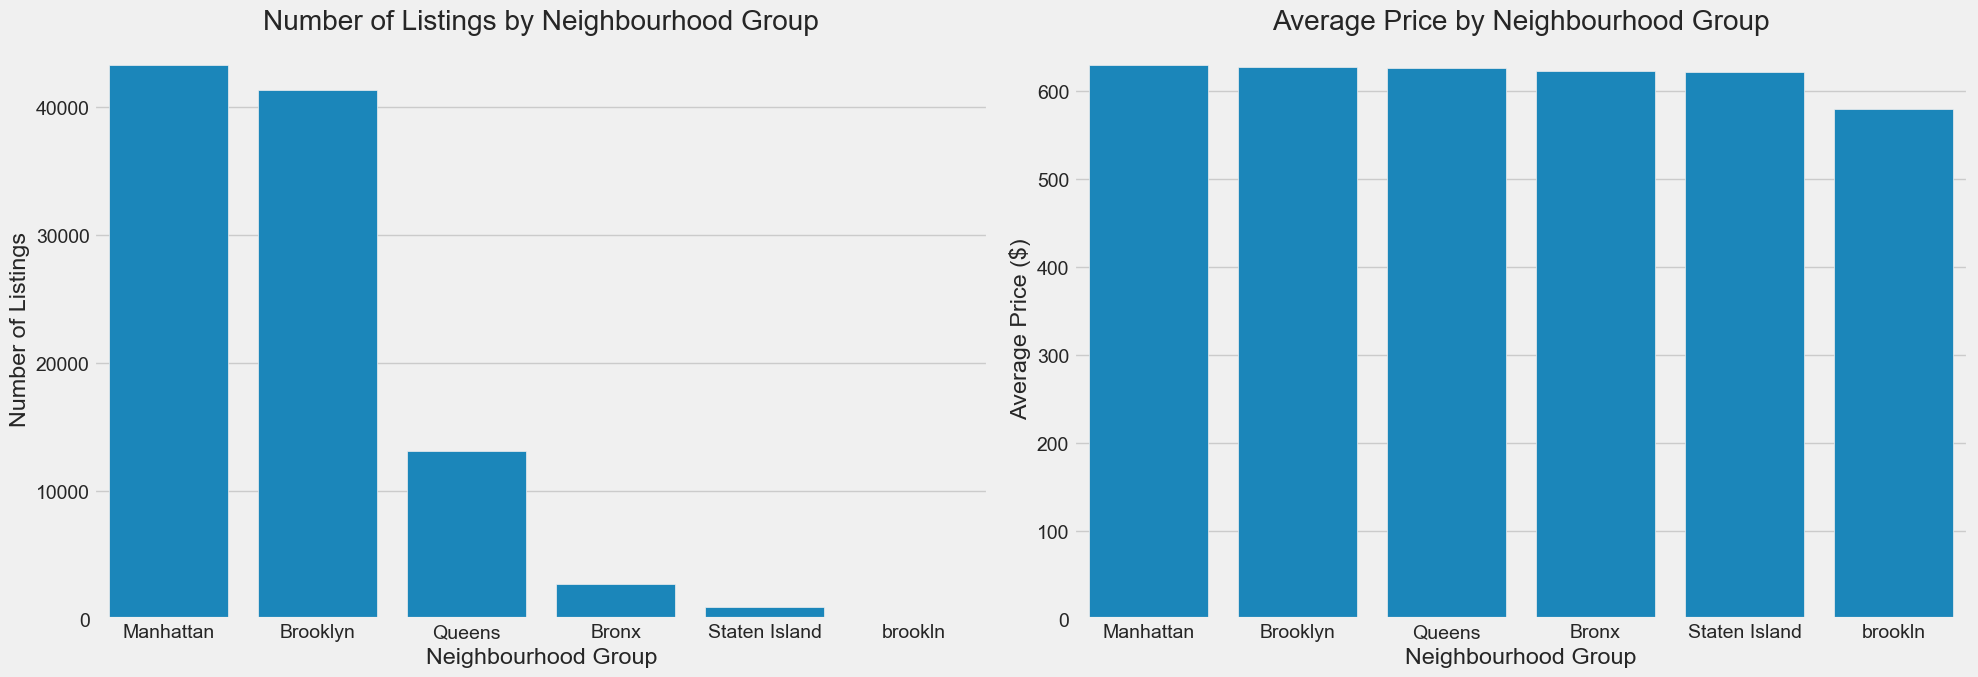

In [33]:
# --- Q2 & Q3: Neighborhood Group Analysis ---
if 'df_cleaned' in locals():
    # Group by neighborhood group to get counts and mean prices
    neighbourhood_stats = df_cleaned.groupby('neighbourhood_group')['price'].agg(['count', 'mean']).sort_values(by='count', ascending=False)
    
    print("Neighborhood Group Statistics (Listings Count & Avg. Price):")
    print(neighbourhood_stats)

    # Create subplots for visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

    # Plot for Number of Listings
    sns.barplot(x=neighbourhood_stats.index, y='count', data=neighbourhood_stats, ax=ax1)
    ax1.set_title('Number of Listings by Neighbourhood Group')
    ax1.set_ylabel('Number of Listings')
    ax1.set_xlabel('Neighbourhood Group')

    # Plot for Average Price
    sns.barplot(x=neighbourhood_stats.index, y='mean', data=neighbourhood_stats.sort_values(by='mean', ascending=False), ax=ax2)
    ax2.set_title('Average Price by Neighbourhood Group')
    ax2.set_ylabel('Average Price ($)')
    ax2.set_xlabel('Neighbourhood Group')

    plt.tight_layout()
    plt.show()

### Q4: Is there a relationship between the construction year of property and price?

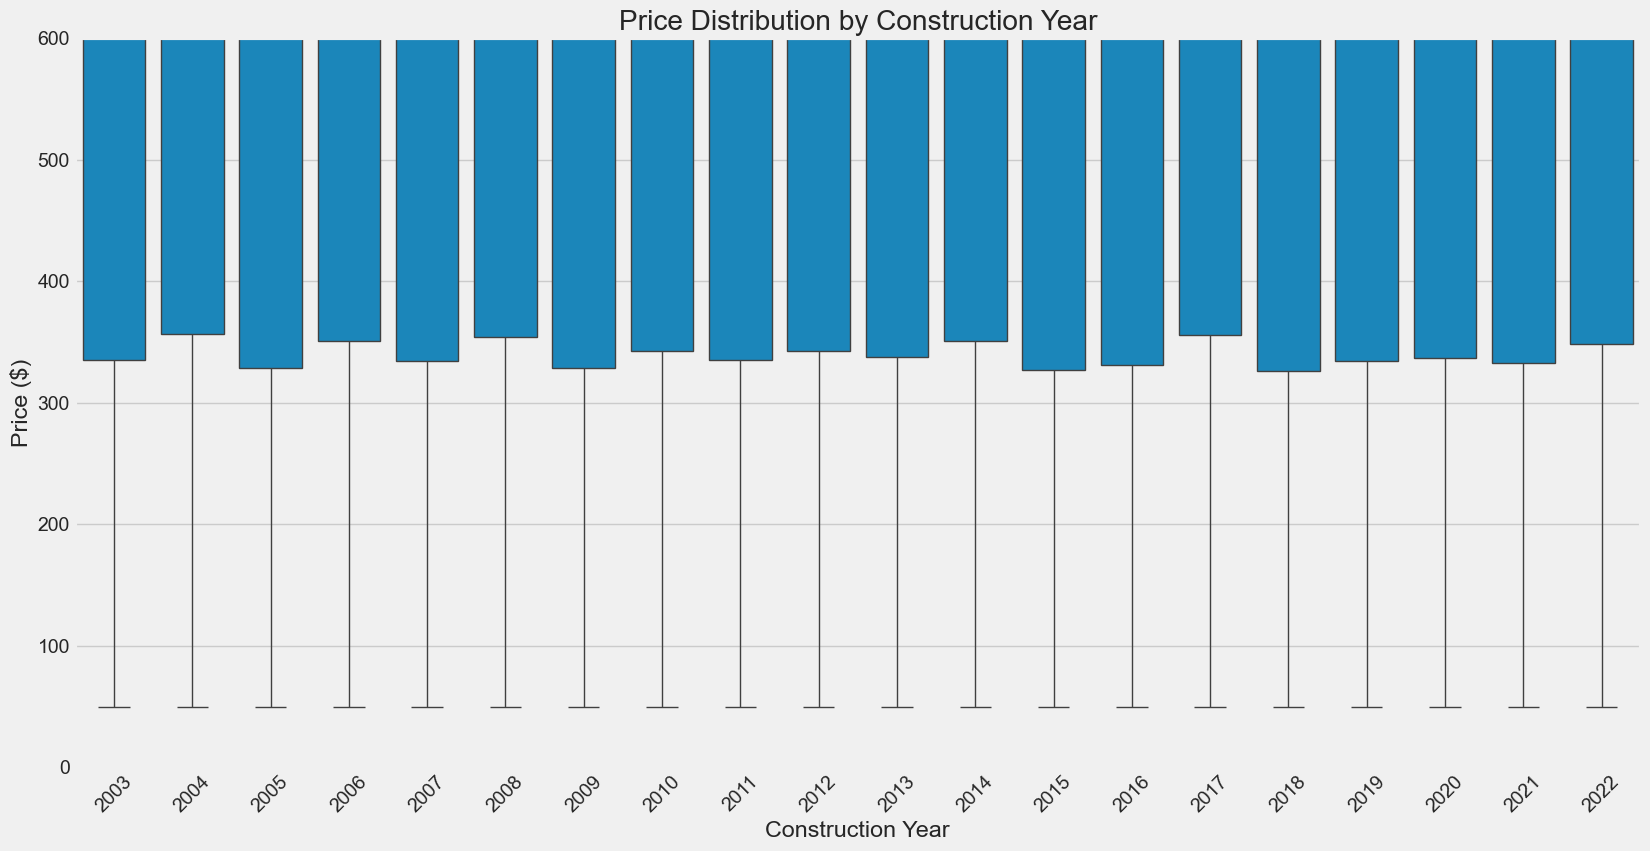


Median Price per Construction Year:
construction_year
2003    627.0
2004    635.0
2005    621.0
2006    637.5
2007    628.0
2008    636.0
2009    619.5
2010    626.0
2011    622.5
2012    622.0
2013    611.0
2014    630.5
2015    605.0
2016    625.0
2017    619.0
2018    621.0
2019    606.0
2020    610.0
2021    637.0
2022    635.0
Name: price, dtype: float64


In [34]:
# --- Q4: Construction Year vs. Price ---
if 'df_cleaned' in locals():
    plt.figure(figsize=(18, 9))

    # We will use a boxplot to see the distribution of prices for each year.
    sns.boxplot(x='construction_year', y='price', data=df_cleaned)

    # We can filter out extreme prices to make the plot more readable
    # Let's focus on prices under $600, as that's where most data likely is.
    plt.ylim(0, 600) 
    
    plt.title('Price Distribution by Construction Year')
    plt.xlabel('Construction Year')
    plt.ylabel('Price ($)')
    plt.xticks(rotation=45) # Rotate x-axis labels for better readability
    plt.show()

    # To get the exact numbers, we can calculate the median price per year
    print("\nMedian Price per Construction Year:")
    median_prices_by_year = df_cleaned.groupby('construction_year')['price'].median().sort_index()
    print(median_prices_by_year)

### Q7: Is there a correlation between the price of a listing and its service fee?

The correlation between price and service fee is: 1.00


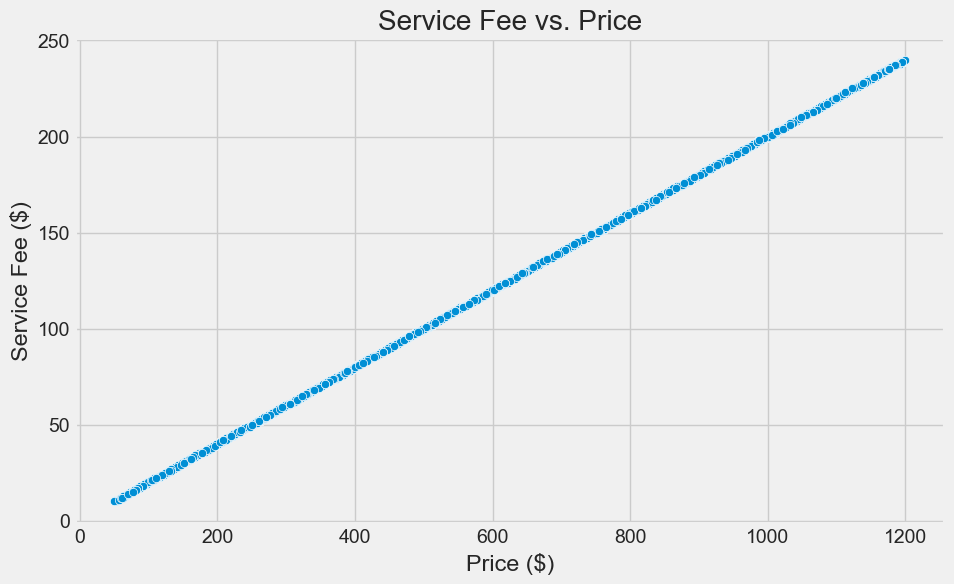

In [35]:
# --- Q7: Price vs. Service Fee Correlation ---
if 'df_cleaned' in locals():
    # Calculate the correlation coefficient
    correlation = df_cleaned['price'].corr(df_cleaned['service_fee'])
    print(f"The correlation between price and service fee is: {correlation:.2f}")

    # Visualize with a scatter plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='price', y='service_fee', data=df_cleaned[df_cleaned['price'] < 1500]) # Filter for clarity
    plt.title('Service Fee vs. Price')
    plt.xlabel('Price ($)')
    plt.ylabel('Service Fee ($)')
    plt.show()